# 1. Environment Setup & Data Loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Load dataset
df = pd.read_csv("/content/Nairobi propertyprices - Sheet1.csv")

# 2. Data Cleaning & Filtering

In [2]:
# Rename columns for consistency
df.columns = ['Price', 'PropertyType', 'Location', 'Bedroom', 'Bathroom', 'HouseSize', 'LandSize']

# Filter: Remove non-residential categories
to_drop = ["Commercial Property", "Industrial Property", "Vacant Land"]
df = df[~df['PropertyType'].isin(to_drop)].copy()

# Fix Typos
df['PropertyType'] = df['PropertyType'].replace({'Townhuse': 'Townhouse'})

# Clean Price: Remove symbols and convert to float
df['Price'] = df['Price'].astype(str).str.replace(r'[^\d.]', '', regex=True).astype(float)

# 3. Advanced Feature Engineering

In [3]:
def convert_units(value):
    if pd.isna(value) or value == "": return None
    val_str = str(value).lower()
    number_match = re.search(r'(\d+\.?\d*)', val_str.replace(',', ''))
    if not number_match: return None

    number = float(number_match.group(1))
    # Convert Acres to Square Meters
    if 'acre' in val_str or re.search(r'\bac\b', val_str):
        return number * 4046.86
    return number

# Apply unit conversion
df['LandSize'] = df['LandSize'].apply(convert_units)
df['HouseSize'] = df['HouseSize'].apply(convert_units)

# Handle Missing Values using Grouped Medians
cols_to_fix = ['HouseSize', 'LandSize', 'Bathroom']
for col in cols_to_fix:
    df[col] = df[col].fillna(df.groupby('PropertyType')[col].transform('median'))

# Filter out rare locations (Noise reduction)
location_counts = df['Location'].value_counts()
frequent_locations = location_counts[location_counts >= 3].index
df = df[df['Location'].isin(frequent_locations)].copy()

# 4. Preprocessing & Data Splitting

In [4]:
# Reorder: Features first, Price (Target) last
df = df[['PropertyType', 'Location', 'Bedroom', 'Bathroom', 'HouseSize', 'LandSize', 'Price']]

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Log-transform target to handle skewness
y_log = np.log1p(y)

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=0)
y_test_actual = np.expm1(y_test_log)

# Define Column Transformer
# Indices: 0:PropertyType, 1:Location, 2:Bedroom, 3:Bathroom, 4:HouseSize, 5:LandSize
ct = ColumnTransformer(transformers=[
    ('num', StandardScaler(), [2, 3, 4, 5]),
    ('cat', OneHotEncoder(handle_unknown='ignore'), [0, 1])
], remainder='passthrough')

X_train_pre = ct.fit_transform(X_train)
X_test_pre = ct.transform(X_test)

# 5. Model Training & Comparison

In [5]:
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(kernel='rbf', C=1e6),
    "Decision Tree": DecisionTreeRegressor(random_state=0),
    "Random Forest": RandomForestRegressor(n_estimators=100, min_samples_split=5, random_state=0)
}

results = []

for name, model in models.items():
    model.fit(X_train_pre, y_train_log)
    preds = np.expm1(model.predict(X_test_pre))

    results.append({
        "Model": name,
        "R2 Score": r2_score(y_test_actual, preds),
        "MAE (KES)": mean_absolute_error(y_test_actual, preds)
    })

# Specialized: Polynomial Regression
poly_reg = PolynomialFeatures(degree=2)
X_poly_train = poly_reg.fit_transform(X_train_pre)
poly_model = LinearRegression().fit(X_poly_train, y_train_log)
poly_preds = np.expm1(poly_model.predict(poly_reg.transform(X_test_pre)))

results.append({
    "Model": "Polynomial Regression",
    "R2 Score": r2_score(y_test_actual, poly_preds),
    "MAE (KES)": mean_absolute_error(y_test_actual, poly_preds)
})

# Display Leaderboard
leaderboard = pd.DataFrame(results).sort_values(by="R2 Score", ascending=False)
print(leaderboard)

                   Model      R2 Score     MAE (KES)
2          Decision Tree  9.040371e-01  7.624032e+06
3          Random Forest  8.774011e-01  1.298852e+07
0      Linear Regression  8.297421e-01  1.438218e+07
4  Polynomial Regression  8.215645e-01  1.424881e+07
1                    SVR -9.779462e+06  3.316429e+10


# 6. Final Evaluation & Visualization

Final Model Average Error (MAPE): 22.38%


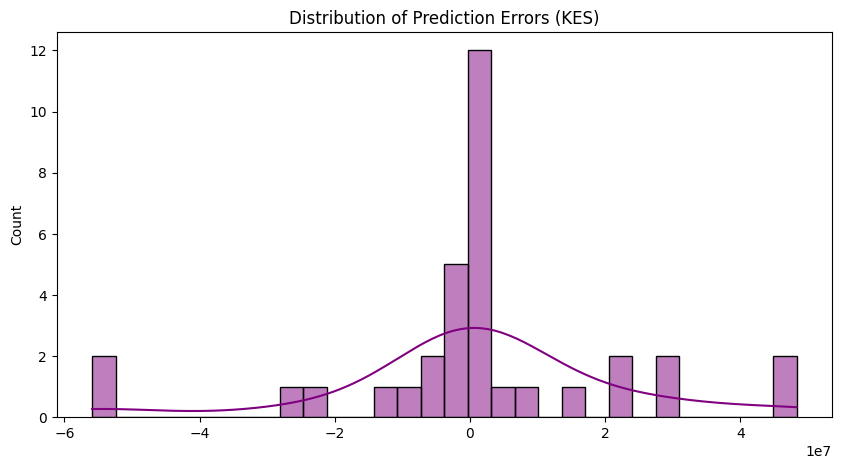

/tmp/ipython-input-4176910291.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', palette='magma', data=importances.sort_values('Importance', ascending=False).head(10))


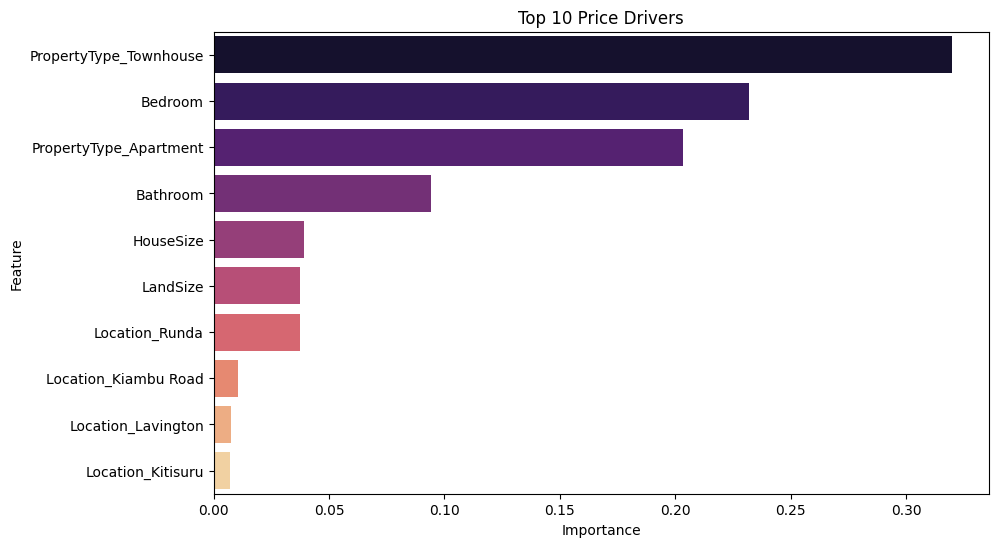

In [7]:
# Using Random Forest as the primary model
y_final_pred = np.expm1(models["Random Forest"].predict(X_test_pre))
residuals = y_test_actual - y_final_pred
mape = np.mean(np.abs(residuals / y_test_actual)) * 100

print(f"Final Model Average Error (MAPE): {mape:.2f}%")

# Residual Distribution
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.title('Distribution of Prediction Errors (KES)')
plt.show()

# Feature Importance
cat_names = ct.named_transformers_['cat'].get_feature_names_out(['PropertyType', 'Location'])
all_names = np.concatenate([['Bedroom', 'Bathroom', 'HouseSize', 'LandSize'], cat_names])
importances = pd.DataFrame({'Feature': all_names, 'Importance': models["Random Forest"].feature_importances_})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', palette='magma', data=importances.sort_values('Importance', ascending=False).head(10))
plt.title('Top 10 Price Drivers')
plt.show()

## PREDICTOR

In [8]:
def get_model_prediction(prop_type, location, bed, bath, house_sqm, land_sqm):

    input_data = pd.DataFrame([[prop_type, location, bed, bath, house_sqm, land_sqm]],
                              columns=['PropertyType', 'Location', 'Bedroom', 'Bathroom', 'HouseSize', 'LandSize'])

    transformed_input = ct.transform(input_data)

    # Predict using the Champion Model (Random Forest)
    prediction_log = models["Random Forest"].predict(transformed_input)

    #  Reverse the Log-Transformation
    final_price = np.expm1(prediction_log)[0]

    return final_price

# --- Test the Predictor ---
test_location = 'Kilimani'
test_type = 'Apartment'
price_estimate = get_model_prediction(test_type, test_location, 3, 2, 150, 0)

print(f"🏠 Property Details: {test_type} in {test_location}")
print(f"💰 Estimated Market Value: KES {price_estimate:,.2f}")

🏠 Property Details: Apartment in Kilimani
💰 Estimated Market Value: KES 24,998,413.31


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
